In [1]:
import torch
import torchaudio
import fairseq

from torchaudio.models.wav2vec2.utils import import_fairseq_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='hindi.ttf')
import IPython
from pydub import AudioSegment

2022-10-18 17:31:18 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [2]:
# %matplotlib inline

from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)

SPEECH_FILE = 'sample.wav'
IPython.display.Audio(SPEECH_FILE)


In [3]:
txt_file = SPEECH_FILE.replace('.wav', '.txt')
with open(txt_file, encoding='utf-8') as f:
    txt = f.read().strip()
words = txt.split()
transcript = words[0]
for word in words[1:]:
    transcript += '|' + word
transcript

'क्या|सेंट|मैरीस|की|एयर|क्वालिटी|घातक|है'

In [4]:
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task(['../models/wav2vec2/hindi/hi.pt'])
model = model[0]
encoder = import_fairseq_model(model.w2v_encoder)
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = encoder(waveform)
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

In [6]:
with open('../models/wav2vec2/hindi/dict.ltr.txt', encoding='utf-8') as f:
    chars = f.readlines()
hindi_chars = [i.split()[0] for i in chars]
greedy_labels = ["<s>", "<pad>", "</s>", "<unk>"] + hindi_chars
labels = tuple(greedy_labels)

('<s>', '<pad>', '</s>', '<unk>', '|', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्')


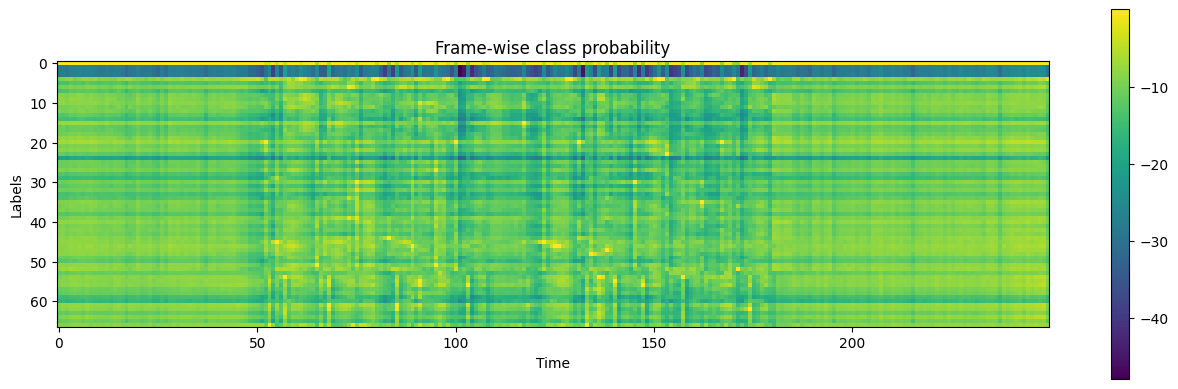

In [7]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [8]:
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('क', 20), ('्', 66), ('य', 45), ('ा', 54), ('|', 4), ('स', 51), ('े', 61), ('ं', 6), ('ट', 30), ('|', 4), ('म', 44), ('ै', 62), ('र', 46), ('ी', 56), ('स', 51), ('|', 4), ('क', 20), ('ी', 56), ('|', 4), ('ए', 15), ('य', 45), ('र', 46), ('|', 4), ('क', 20), ('्', 66), ('व', 48), ('ा', 54), ('ल', 47), ('ि', 55), ('ट', 30), ('ी', 56), ('|', 4), ('घ', 23), ('ा', 54), ('त', 35), ('क', 20), ('|', 4), ('ह', 52), ('ै', 62)]


In [19]:
dictionary

{'<s>': 0,
 '<pad>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'ँ': 5,
 'ं': 6,
 'ः': 7,
 'अ': 8,
 'आ': 9,
 'इ': 10,
 'ई': 11,
 'उ': 12,
 'ऊ': 13,
 'ऋ': 14,
 'ए': 15,
 'ऐ': 16,
 'ऑ': 17,
 'ओ': 18,
 'औ': 19,
 'क': 20,
 'ख': 21,
 'ग': 22,
 'घ': 23,
 'ङ': 24,
 'च': 25,
 'छ': 26,
 'ज': 27,
 'झ': 28,
 'ञ': 29,
 'ट': 30,
 'ठ': 31,
 'ड': 32,
 'ढ': 33,
 'ण': 34,
 'त': 35,
 'थ': 36,
 'द': 37,
 'ध': 38,
 'न': 39,
 'प': 40,
 'फ': 41,
 'ब': 42,
 'भ': 43,
 'म': 44,
 'य': 45,
 'र': 46,
 'ल': 47,
 'व': 48,
 'श': 49,
 'ष': 50,
 'स': 51,
 'ह': 52,
 '़': 53,
 'ा': 54,
 'ि': 55,
 'ी': 56,
 'ु': 57,
 'ू': 58,
 'ृ': 59,
 'ॅ': 60,
 'े': 61,
 'ै': 62,
 'ॉ': 63,
 'ो': 64,
 'ौ': 65,
 '्': 66}

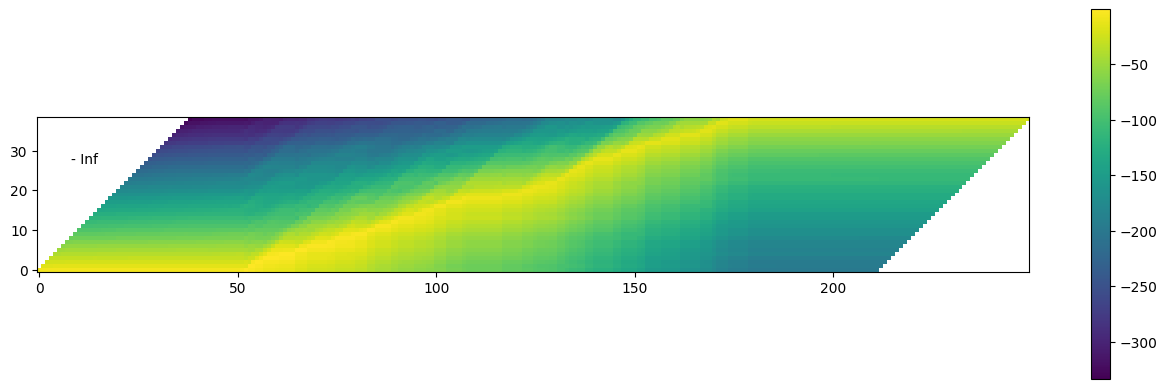

In [9]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [10]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)

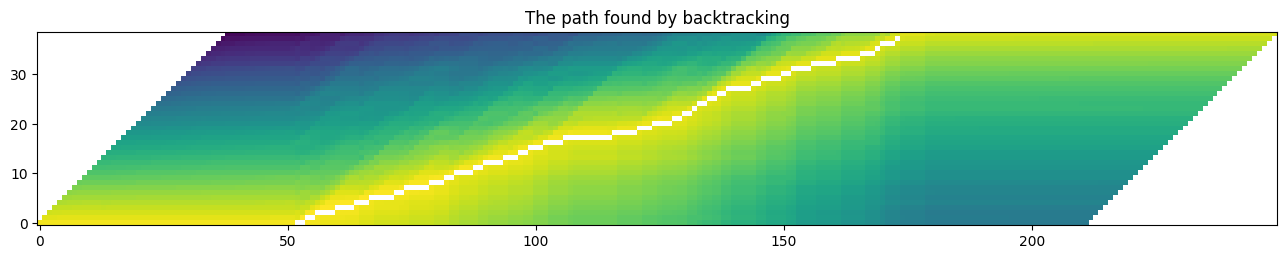

In [11]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()


In [12]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

क	(0.93): [   52,    53)
्	(0.93): [   53,    55)
य	(0.97): [   55,    57)
ा	(0.94): [   57,    61)
|	(0.86): [   61,    65)
स	(0.98): [   65,    68)
े	(0.90): [   68,    73)
ं	(0.62): [   73,    75)
ट	(0.84): [   75,    80)
|	(0.98): [   80,    83)
म	(1.00): [   83,    85)
ै	(0.83): [   85,    89)
र	(0.97): [   89,    91)
ी	(0.80): [   91,    95)
स	(0.81): [   95,    98)
|	(0.95): [   98,   100)
क	(0.99): [  100,   103)
ी	(0.99): [  103,   107)
|	(0.91): [  107,   117)
ए	(0.99): [  117,   122)
य	(0.98): [  122,   125)
र	(0.67): [  125,   129)
|	(0.86): [  129,   131)
क	(0.99): [  131,   133)
्	(0.97): [  133,   134)
व	(0.97): [  134,   136)
ा	(0.88): [  136,   138)
ल	(1.00): [  138,   140)
ि	(0.99): [  140,   145)
ट	(0.99): [  145,   147)
ी	(0.96): [  147,   151)
|	(0.60): [  151,   153)
घ	(1.00): [  153,   157)
ा	(0.99): [  157,   162)
त	(1.00): [  162,   167)
क	(0.98): [  167,   170)
|	(1.00): [  170,   171)
ह	(1.00): [  171,   174)
ै	(0.98): [  174,   175)


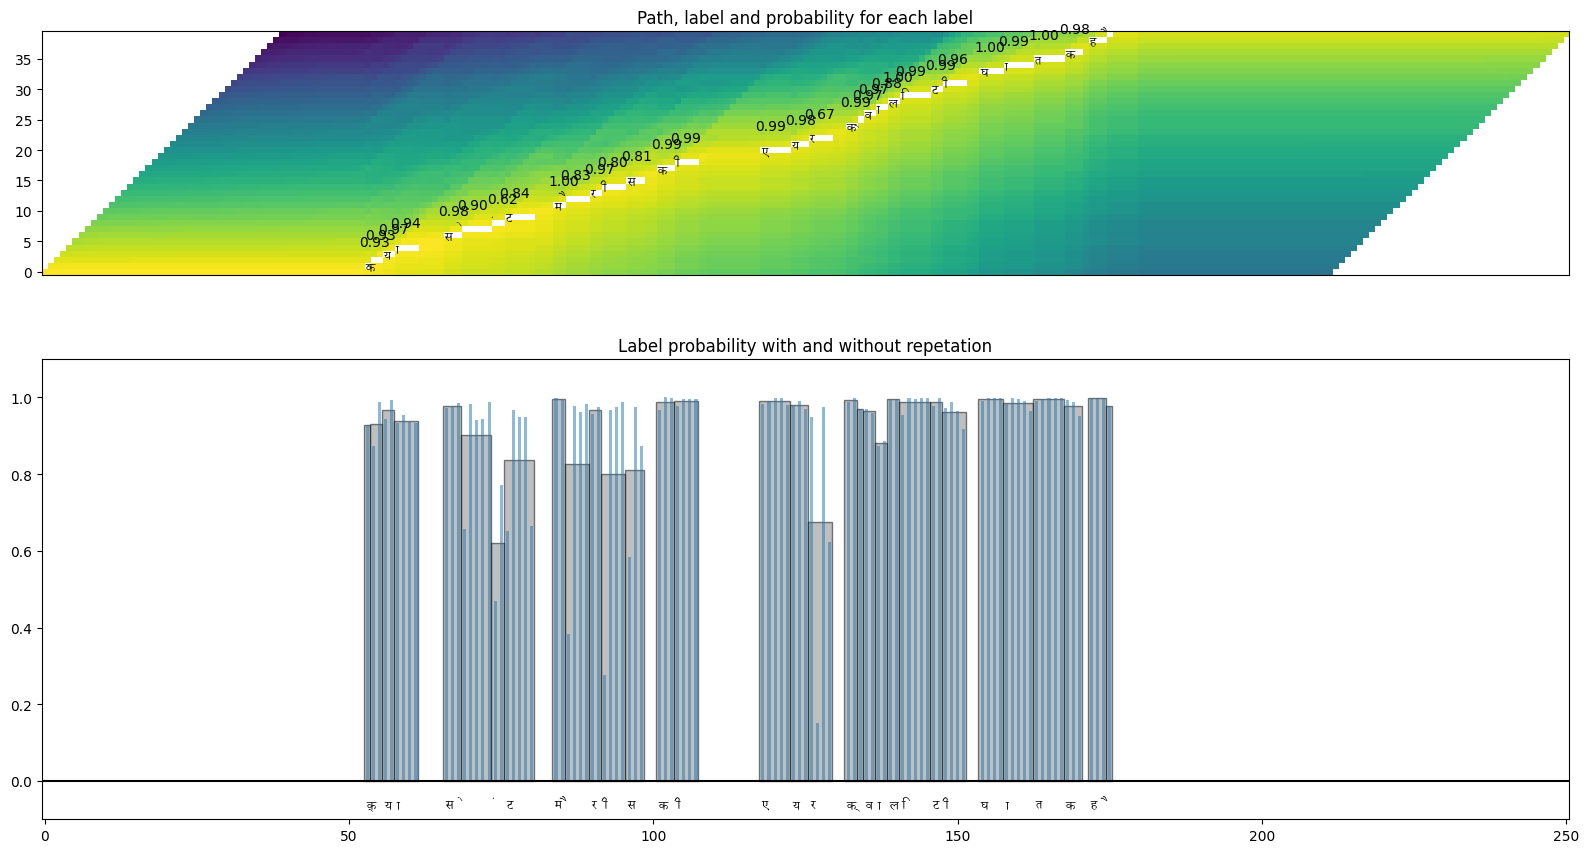

In [13]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold", fontproperties=prop)
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold", fontproperties=prop)
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [14]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

क्या	(0.94): [   52,    61)
सेंट	(0.86): [   65,    80)
मैरीस	(0.86): [   83,    98)
की	(0.99): [  100,   107)
एयर	(0.88): [  117,   129)
क्वालिटी	(0.97): [  131,   151)
घातक	(0.99): [  153,   170)
है	(0.99): [  171,   175)


321.28


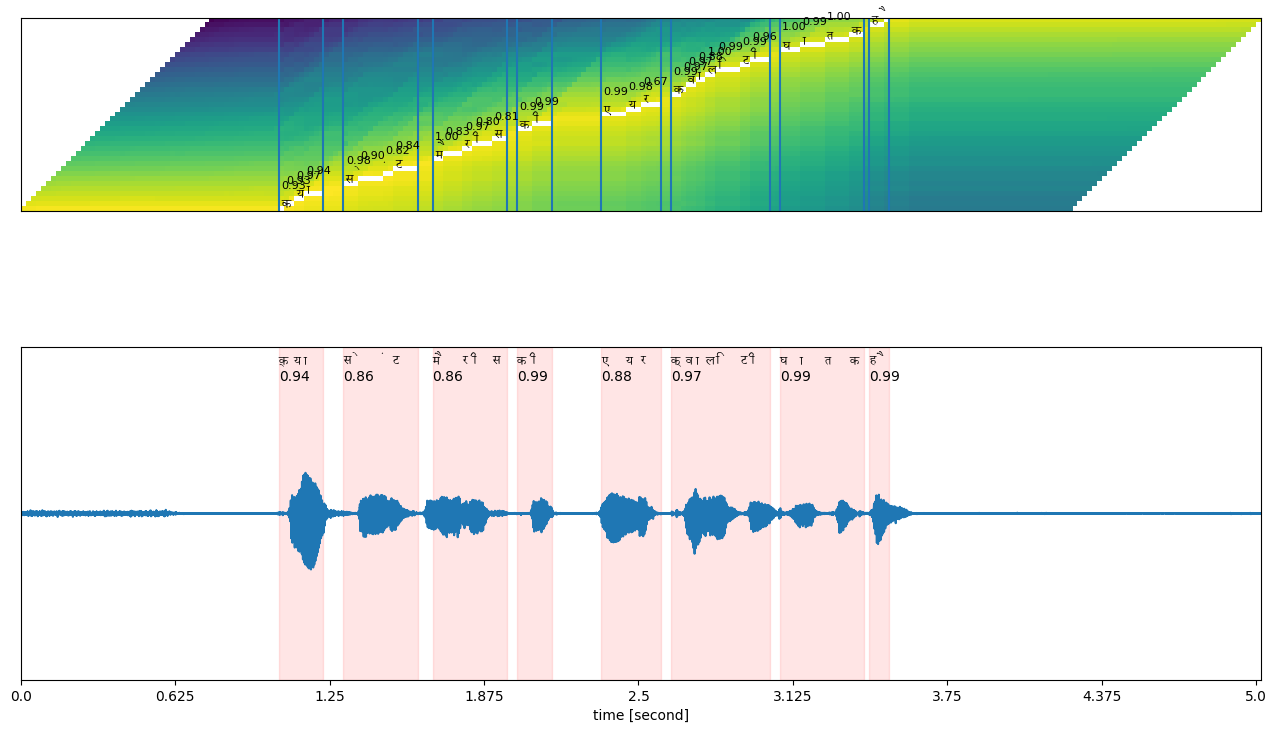

In [15]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3), fontproperties=prop)
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    print(ratio)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9), fontproperties=prop)
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / 16000)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()

In [16]:
wav = AudioSegment.from_wav(SPEECH_FILE)

In [30]:
def clip(wav, start, end):
    s = (start*321.8)/16000
    print(s)
    e = (end*321.8)/16000
    print(e)
    return wav[s*1000:e*1000]

In [31]:
clipped_audio = clip(wav, 51, 61)
clipped_audio

1.0257375
1.2268625


tensor(0.0003)